In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q opendatasets

In [3]:
import opendatasets as od
import pandas as pd
import torch
import os
import glob
from torchvision import transforms
from PIL import Image
import cv2
from tqdm.auto import tqdm
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [7]:
od.download('https://www.kaggle.com/datasets/xyaustin/messidor2?fbclid=IwAR0RH5vzEIfNKtBW94j_Ir0LkAW4FQty0ePjPrUrn9HKc52KeLsDmMciaZU')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hienliu
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:52<00:00, 46.5MB/s]


In [8]:
df = pd.read_csv('/content/messidor2/messidor-2/messidor_data.csv')
df

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0.0,0.0,1
1,20051020_43832_0100_PP.png,1.0,0.0,1
2,20051020_43882_0100_PP.png,1.0,0.0,1
3,20051020_43906_0100_PP.png,2.0,1.0,1
4,20051020_44261_0100_PP.png,0.0,0.0,1
...,...,...,...,...
1743,IM004806.jpg,0.0,0.0,1
1744,IM004811.jpg,1.0,0.0,1
1745,IM004812.jpg,2.0,0.0,1
1746,IM004831.jpg,0.0,0.0,1


In [15]:
df = pd.read_csv('/content/messidor2/messidor-2/messidor_data.csv')
df.image_id = '/content/messidor2/messidor-2/images/' + df.image_id
df = df.dropna()
df

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable
0,/content/messidor2/messidor-2/images/20051020_...,0.0,0.0,1
1,/content/messidor2/messidor-2/images/20051020_...,1.0,0.0,1
2,/content/messidor2/messidor-2/images/20051020_...,1.0,0.0,1
3,/content/messidor2/messidor-2/images/20051020_...,2.0,1.0,1
4,/content/messidor2/messidor-2/images/20051020_...,0.0,0.0,1
...,...,...,...,...
1743,/content/messidor2/messidor-2/images/IM004806.jpg,0.0,0.0,1
1744,/content/messidor2/messidor-2/images/IM004811.jpg,1.0,0.0,1
1745,/content/messidor2/messidor-2/images/IM004812.jpg,2.0,0.0,1
1746,/content/messidor2/messidor-2/images/IM004831.jpg,0.0,0.0,1


In [10]:
from torchvision.transforms import functional as F
def transform_image(image):

    r_num = torch.randint(90, 270, size=[1]).item()
    image = F.rotate(image, r_num)

    if r_num % 3 == 0:
        image = F.hflip(image)

    elif r_num % 3 == 1:
        image = F.vflip(image)

    else:
        image = F.hflip(image)
        image = F.vflip(image)

    return image

In [11]:
def get_aug_times(max_sample, samples):
  aug_samples = max_sample - samples
  aug_times = np.floor(aug_samples / samples)
  remainder = aug_samples % samples
  return f'Number of Aug is: {samples} * {aug_times} + {remainder}'

In [16]:
X_train, X_test_, y_train, y_test_ = train_test_split(df, df.adjudicated_dr_grade, test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

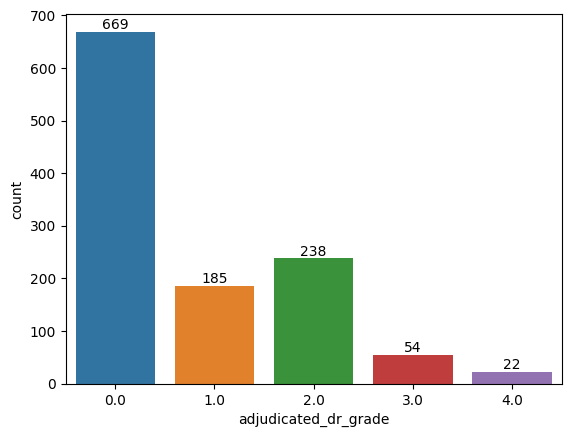

In [17]:
ax = sns.countplot(x=X_train.adjudicated_dr_grade)
for container in ax.containers:
    ax.bar_label(container)

In [18]:
print(get_aug_times(669, 185))
print(get_aug_times(669, 238))
print(get_aug_times(669, 54))
print(get_aug_times(669, 22))

Number of Aug is: 185 * 2.0 + 114
Number of Aug is: 238 * 1.0 + 193
Number of Aug is: 54 * 11.0 + 21
Number of Aug is: 22 * 29.0 + 9


In [19]:
os.makedirs('Augumentation_Image/MESSIDOR2')
aug_dict = {'image_id': [],
            'adjudicated_dr_grade': []}

In [22]:
for i in tqdm(range(3)):

  seed = i + 43
  label = 1
  torch.manual_seed(seed)
  print(seed)

  if i == 2:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values[:114]
  else:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values

  for path in tqdm(aug_data):
    img = Image.open(path)
    trans_img = transform_image(img)
    SAVE_NAME = f'AUG_ADJUDICATED_DR_GRADE_{label}_{seed}_' + path.split('/')[-1]
    aug_dict['image_id'].append(SAVE_NAME.split('.')[0])
    aug_dict['adjudicated_dr_grade'].append(label)
    trans_img.save('/content/Augumentation_Image/MESSIDOR2/' + SAVE_NAME)

  0%|          | 0/3 [00:00<?, ?it/s]

43


  0%|          | 0/185 [00:00<?, ?it/s]

44


  0%|          | 0/185 [00:00<?, ?it/s]

45


  0%|          | 0/114 [00:00<?, ?it/s]

In [23]:
times = 2
for i in tqdm(range(times)):

  seed = i + 43
  label = 2
  torch.manual_seed(seed)
  print(seed)

  if i == times - 1:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values[:193]
  else:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values

  for path in tqdm(aug_data):
    img = Image.open(path)
    trans_img = transform_image(img)
    SAVE_NAME = f'AUG_ADJUDICATED_DR_GRADE_{label}_{seed}_' + path.split('/')[-1]
    aug_dict['image_id'].append(SAVE_NAME.split('.')[0])
    aug_dict['adjudicated_dr_grade'].append(label)
    trans_img.save('/content/Augumentation_Image/MESSIDOR2/' + SAVE_NAME)

  0%|          | 0/2 [00:00<?, ?it/s]

43


  0%|          | 0/238 [00:00<?, ?it/s]

44


  0%|          | 0/193 [00:00<?, ?it/s]

In [24]:
times = 12
for i in tqdm(range(times)):

  seed = i + 43
  label = 3
  torch.manual_seed(seed)
  print(seed)

  if i == times - 1:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values[:21]
  else:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values

  for path in tqdm(aug_data):
    img = Image.open(path)
    trans_img = transform_image(img)
    SAVE_NAME = f'AUG_ADJUDICATED_DR_GRADE_{label}_{seed}_' + path.split('/')[-1]
    aug_dict['image_id'].append(SAVE_NAME.split('.')[0])
    aug_dict['adjudicated_dr_grade'].append(label)
    trans_img.save('/content/Augumentation_Image/MESSIDOR2/' + SAVE_NAME)

  0%|          | 0/12 [00:00<?, ?it/s]

43


  0%|          | 0/54 [00:00<?, ?it/s]

44


  0%|          | 0/54 [00:00<?, ?it/s]

45


  0%|          | 0/54 [00:00<?, ?it/s]

46


  0%|          | 0/54 [00:00<?, ?it/s]

47


  0%|          | 0/54 [00:00<?, ?it/s]

48


  0%|          | 0/54 [00:00<?, ?it/s]

49


  0%|          | 0/54 [00:00<?, ?it/s]

50


  0%|          | 0/54 [00:00<?, ?it/s]

51


  0%|          | 0/54 [00:00<?, ?it/s]

52


  0%|          | 0/54 [00:00<?, ?it/s]

53


  0%|          | 0/54 [00:00<?, ?it/s]

54


  0%|          | 0/21 [00:00<?, ?it/s]

In [25]:
times = 30
for i in tqdm(range(times)):

  seed = i + 43
  label = 4
  torch.manual_seed(seed)
  print(seed)

  if i == times - 1:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values[:9]
  else:
    aug_data = X_train[X_train.adjudicated_dr_grade==label].image_id.values

  for path in tqdm(aug_data):
    img = Image.open(path)
    trans_img = transform_image(img)
    SAVE_NAME = f'AUG_ADJUDICATED_DR_GRADE_{label}_{seed}_' + path.split('/')[-1]
    aug_dict['image_id'].append(SAVE_NAME.split('.')[0])
    aug_dict['adjudicated_dr_grade'].append(label)
    trans_img.save('/content/Augumentation_Image/MESSIDOR2/' + SAVE_NAME)

  0%|          | 0/30 [00:00<?, ?it/s]

43


  0%|          | 0/22 [00:00<?, ?it/s]

44


  0%|          | 0/22 [00:00<?, ?it/s]

45


  0%|          | 0/22 [00:00<?, ?it/s]

46


  0%|          | 0/22 [00:00<?, ?it/s]

47


  0%|          | 0/22 [00:00<?, ?it/s]

48


  0%|          | 0/22 [00:00<?, ?it/s]

49


  0%|          | 0/22 [00:00<?, ?it/s]

50


  0%|          | 0/22 [00:00<?, ?it/s]

51


  0%|          | 0/22 [00:00<?, ?it/s]

52


  0%|          | 0/22 [00:00<?, ?it/s]

53


  0%|          | 0/22 [00:00<?, ?it/s]

54


  0%|          | 0/22 [00:00<?, ?it/s]

55


  0%|          | 0/22 [00:00<?, ?it/s]

56


  0%|          | 0/22 [00:00<?, ?it/s]

57


  0%|          | 0/22 [00:00<?, ?it/s]

58


  0%|          | 0/22 [00:00<?, ?it/s]

59


  0%|          | 0/22 [00:00<?, ?it/s]

60


  0%|          | 0/22 [00:00<?, ?it/s]

61


  0%|          | 0/22 [00:00<?, ?it/s]

62


  0%|          | 0/22 [00:00<?, ?it/s]

63


  0%|          | 0/22 [00:00<?, ?it/s]

64


  0%|          | 0/22 [00:00<?, ?it/s]

65


  0%|          | 0/22 [00:00<?, ?it/s]

66


  0%|          | 0/22 [00:00<?, ?it/s]

67


  0%|          | 0/22 [00:00<?, ?it/s]

68


  0%|          | 0/22 [00:00<?, ?it/s]

69


  0%|          | 0/22 [00:00<?, ?it/s]

70


  0%|          | 0/22 [00:00<?, ?it/s]

71


  0%|          | 0/22 [00:00<?, ?it/s]

72


  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
aug_data = pd.DataFrame(aug_dict)
aug_data.to_csv('/content/drive/MyDrive/UIT/Hien/Data/aug_messidor2.csv', index=False)

In [27]:
image_paths = glob.glob('/content/Augumentation_Image/MESSIDOR2/*')
len(image_paths), len(aug_data)

(2177, 2177)

In [28]:
import shutil
shutil.make_archive('/content/drive/MyDrive/UIT/Hien/Data/messidor2_aug_images', 'zip', '/content/Augumentation_Image/MESSIDOR2')

'/content/drive/MyDrive/UIT/Hien/Data/messidor2_aug_images.zip'

In [29]:
os.mkdir('MESSIDOR2_TEST')

In [30]:
!unzip /content/drive/MyDrive/UIT/Hien/Data/messidor2_aug_images.zip -d /content/MESSIDOR2_TEST

Archive:  /content/drive/MyDrive/UIT/Hien/Data/messidor2_aug_images.zip
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_1_44_IM001805.jpg  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_3_52_20051020_45068_0100_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_3_50_20051020_54209_0100_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_1_43_20060407_41330_0200_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_2_44_20060523_45235_0100_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_1_43_20051202_55498_0400_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_1_44_20051116_54587_0400_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_1_43_20060412_61316_0200_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_3_49_20051213_62383_0100_PP.png  
  inflating: /content/MESSIDOR2_TEST/AUG_ADJUDICATED_DR_GRADE_2_44_20060412_61

In [31]:
image_paths = glob.glob('/content/MESSIDOR2_TEST/*')
len(image_paths)

2177